* This implements the control flow for HI-LO Card Counting, with multiple splits.
* Primarily intended for generating one trajectory.

In [2]:
import pandas as pd
import random
from matplotlib import pyplot 
import numpy as np

In [3]:
columns = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
index = [i for i in range(5, 22)]
index2 = ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']
index3 = ['2, 2','3, 3', '4, 4', '5, 5', '6, 6', '7, 7', '8, 8', '9, 9', '10, 10', 'J, J', 'Q, Q', 'K, K', 'A, A']
indices = index + index2 + index3
basic_strategy_table = pd.read_csv('basic-strategy.csv', header=None)
basic_strategy_table.index = indices
basic_strategy_table.columns = columns

basic_strategy_table_no_doubling = pd.read_csv('basic-strategy-no-doubling.csv', header=None)
basic_strategy_table_no_doubling.index = indices
basic_strategy_table_no_doubling.columns = columns

In [4]:
def getcards(decks=1):
    """Brings out a number of sealed decks of cards in their original order to the virutal gaming table.

    Creates a dictionary tracking the name of each card, its quantity, and its value
    
    Keyword argument:
        decks {int} -- the number of 52-card decks that the casino is using (default 1)
    
    Returns:
        dictionary{keys: values} -- dictionary object where keys are the card name (e.g. 'K' for King )
                                    and where the values are a list object containing the card's quantity and its value.
                                    
    The value for the ace contains three elements, as aces can further take on the value of 1 or 11, depending on 
    the context of the hand. No distinction is made between card suits, i.e. spades, hearts, clubs, diamonds.
    """
    
    deck = {}
    total_cards = decks * 52
    card_quantity = int(total_cards / 13)
    
    deck['A'] = [card_quantity, 1, 11]

    for card in range(2, 11):
        deck[str(card)] = [card_quantity, card]
    
    for card in "JQK":
        deck[str(card)] = [card_quantity, 10]
        
    return deck, total_cards

In [5]:
def shuffler(deck, total_cards):
    
    """Shuffles the decks of cards, and places them inside the virtual gaming table card-shoe."""
    
    shuffled_shoe = []
    
    while len(shuffled_shoe) < total_cards:
        draw = random.choice(list(deck))
        if deck[draw][0] == 0:
            pass
        else:
            deck[draw][0] -= 1
            shuffled_shoe.append(draw)
            
    return shuffled_shoe

In [6]:
def player_bets(truecount, total_cards_dealt):
    
    """A specification of player betting behaviour. Uses the truecount from the previous round to inform betting behaviour.
    If it is the first round of a shoe, then the minimum bet is placed."""
    
    if total_cards_dealt == 0:
        current_hand_bet = bet_per_round
        print("As this is the first round of the shoe, there is no available statistical information to use to place bets.")
        print("I will therefore bet {}".format(current_hand_bet))
    else:
        if (truecount <= 2):
            current_hand_bet = bet_per_round
            print("As the true count is {}, I will bet {}".format(truecount, current_hand_bet))
        if truecount > 2:
            current_hand_bet = 20 * bet_per_round
            print("As the true count is {}, I will bet {}".format(truecount, current_hand_bet))
    return current_hand_bet

In [7]:
def openinghand():
    
    """Deals two cards to the player, and one to the dealer from the shuffled shoe. Outputs a message if there is Blackjack
    
    Cards are taken sequentially from the shuffled card shoe, beginning with the last element of the shuffled shoe list object
    and working in reverse order."""
    
    player = []
    dealer = []

    player.append(shuffled_shoe.pop())
    player.append(shuffled_shoe.pop())
    
    dealer.append(shuffled_shoe.pop())
    
    if ('A' in player) and (('10' in player) or ('J' in player) or ('Q' in player) or ('K' in player)):
        player_blackjack = 1
        print("Blackjack, house pays out at 3:2")
    else:
        player_blackjack = 0
        print("No Blackjack this time")
        
    return player, dealer, player_blackjack

In [8]:
def decode(action):
    if action == 'Sp':
        message = 'split'
    elif action == 'H':
        message = 'hit'
    elif action == 'D':
        message = 'double down'
    else:
        message = 'stick'
    return message

In [9]:
def basic_player_multiple_hits(player, dealer, player_blackjack):
    
    if len(player) == 2:
        
        if player_blackjack == 1:
            cardvalues = [21]
            decision = 'S'
            print("It's my lucky day")
        else:
            if player[0] == player[1]:
                lookup_pairs = player[0] + ", " + player[1]
                decision = basic_strategy_table.loc[lookup_pairs, dealer[0]]
                print("As I have a pair of {}s".format(player[0]))
            elif ('A' in player):
                if player[0] == 'A':
                    lookup_soft_total = player[0] + player[1]
                else:
                    lookup_soft_total = player[1] + player[0]
                
                decision = basic_strategy_table.loc[lookup_soft_total, dealer[0]]
                print("As I have a soft total")
            else:
                cardvalues = []
                for card in player:
                    cardvalues.append(deck[card][1])
                
                lookup_hard_total = sum(cardvalues)
                decision = basic_strategy_table.loc[lookup_hard_total, dealer[0]]
                print("I have a total of {}.".format(lookup_hard_total))
        
    if len(player) > 2: 
        
        if 'A' in player:  # check if the >3 hand has an ace, i.e. is potentially soft.
            if player[0] != 'A':  # re-order dual ace to the left
                ace_index = player.index('A')  
                player[0], player[ace_index] = player[ace_index], player[0]
            
            cardvalues_no_ace = [deck[card][1] for card in player[1::]]
            
            if sum(cardvalues_no_ace) <= 10: # check soft totals
                lookup_soft_total = player[0] + str(sum(cardvalues_no_ace))

                decision = basic_strategy_table_no_doubling.loc[lookup_soft_total, dealer[0]]
                print("As I have a soft {}, that is {} or {}.".format(11 + sum(cardvalues_no_ace), 1 + sum(cardvalues_no_ace), 11 + sum(cardvalues_no_ace)))
            else:
                lookup_hard_total = deck['A'][1] + sum(cardvalues_no_ace) # variable naming, hard total as ace can only take value 1 now
                
                decision = basic_strategy_table_no_doubling.loc[lookup_hard_total, dealer[0]]
                print("I have {}.".format(1 + sum(cardvalues_no_ace)))
        else:
            cardvalues = [deck[card][1] for card in player]
            lookup_hard_total = sum(cardvalues)
            
            decision = basic_strategy_table_no_doubling.loc[lookup_hard_total, dealer[0]]
            print("I have {}.".format(sum(cardvalues)))
            
    return decision

In [10]:
def player_action(player, decision):
    
    if decision == 'S':
        print(player)
        return player# -> go to dealerturn()

    if decision == 'D':
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        print(player) #-> go to dealerturn(), and also have to modify payout
        return player
        
    
    if decision == 'H':
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        print(player) #-> now there are three cards in player hand and one in dealer
        return player
        

    if decision == 'Sp': 
        multiple_hand_player = [player[i:i+1] for i in range(len(player))] #splits the player hand into two cards and places them in two sub-hands
    
        drawcard1 = shuffled_shoe.pop()
        drawcard2 = shuffled_shoe.pop()
    
        print("After, splitting, I receive {} and {} in each of my hands".format(drawcard1, drawcard2))
    
        multiple_hand_player[0].append(drawcard1)
        multiple_hand_player[1].append(drawcard2)
        
        print("My new hands are: " + str(multiple_hand_player))
        
    return multiple_hand_player

In [11]:
# Busting module
# O/S - simplify the logic, if possible. Make it a function of a generic argument like hand?

def check_if_bust(player):
    if 'A' in player:
        if player[0] != 'A':
            ace_index = player.index('A')
            player[0], player[ace_index] = player[ace_index], player[0]
            
        card_values_no_ace = [deck[card][1] for card in player[1::]]
        
        if sum(card_values_no_ace) <= 10:
            bust_indicator = 0
        elif sum(card_values_no_ace) > 20:
            bust_indicator = 1
        else:
            bust_indicator = 0
    else:
        card_values = [deck[card][1] for card in player]
        
        if sum(card_values) > 21:
            bust_indicator = 1
        else:
            bust_indicator = 0
            
    return bust_indicator

In [12]:
def player_turn(player, decision):

    while decision == 'H':
        playerbust_indicator = check_if_bust(player)
        
        if playerbust_indicator == 0:
            print("Continue decision-action sequence")
            decision = basic_player_multiple_hits(player, dealer, player_blackjack)
            print(decision)
            player = player_action(player, decision)
            print(player)
        else:
            print("Now dealer's turn as I have gone bust, CF takes over")
            break
    else:
        if decision == 'S':
            print("Decision-action sequence terminated by decision = 'S'")
            print("Go to dealer, CF takes over")
            playerbust_indicator = 0
        elif decision == 'D':
            print("Decision-action sequence terminated by decision = 'D'")
            print("Go to dealer, CF takes over")
            playerbust_indicator = check_if_bust(player)
            
            if playerbust_indicator:
                print("Player doubled and busted.")
            else:
                print("Player doubled and did not bust.")
                
        elif decision == 'Sp':  # This part was added hastily - you need to think out the logic of this through.
            playerbust_indicator = check_if_bust(player)
        
    return player, decision, playerbust_indicator

In [13]:
def player_action_parent(player, decision):
    
    if decision == 'S':
        print(player)
        return player# -> go to dealerturn()

    if decision == 'D':
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        print(player) #-> go to dealerturn(), and also have to modify payout
        return player
        
    
    if decision == 'H':
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        print(player) #-> now there are three cards in player hand and one in dealer
        return player
        

    if decision == 'Sp': 
        player_split_hands = [player[i:i+1] for i in range(len(player))] #splits the player hand into two cards and places them in two sub-hands
    
        drawcard1 = shuffled_shoe.pop()
        drawcard2 = shuffled_shoe.pop()
                    
        print("After, splitting, I receive {} and {} in each of my hands".format(drawcard1, drawcard2))
    
        player_split_hands[0].append(drawcard1)
        player_split_hands[1].append(drawcard2)
        
        if [hand[0] == hand[1] for hand in player_split_hands] == [True, False]:  # if additional pairs are drawn then these are placed at the end of the list of lists.
            player_split_hands[0], player_split_hands[1] = player_split_hands[1], player_split_hands[0]
        
        print("My new hands are: " + str(player_split_hands))
        
        return player_split_hands

In [14]:
def player_action_child(player, decision):
    
    if decision == 'S':
        print(player)
        return player# -> go to dealerturn()

    if decision == 'D':
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        print(player) #-> go to dealerturn(), and also have to modify payout
        return player
        
    
    if decision == 'H':
        drawcard = shuffled_shoe.pop()
        player.append(drawcard)
        print(player) #-> now there are three cards in player hand and one in dealer
        return player  

    if decision == 'Sp':
        
        index = player_split_hands.index(player) 
        
        player_split_hands.insert(index + 1, list(player.pop()))  # Turn one hand with a pair into two separate hands inside player_split_hands
    
        drawcard1 = shuffled_shoe.pop()
        drawcard2 = shuffled_shoe.pop()
    
        print("After, splitting, I receive {} and {} in each of my hands".format(drawcard1, drawcard2))
    
        player_split_hands[index].append(drawcard1)
        player_split_hands[index + 1].append(drawcard2)
        
        if [hand[0] == hand[1] for hand in player_split_hands[index:index + 2]] == [True, False]: # Ensures that if further pairs are drawn these are not resolved first.
            player_split_hands[index], player_split_hands[index + 1] = player_split_hands[index + 1], player_split_hands[index]
        
        print("My new hands are: {} and {}.".format(player_split_hands[index], player_split_hands[index + 1]))
        
        player = player_split_hands[index] 
        
    return player

In [15]:
def player_multiple_turns(player_split_hands):
    
    decision_list = []
    playerbust_indicator_list = []
    
    for hand in player_split_hands:
        
        print("Loop is working on hand {}".format(hand))
    
        if ('A' in hand) and (('10' in hand) or ('J' in hand) or ('Q' in hand) or ('K' in hand)):
            decision = 'S'
        else:
            decision = basic_player_multiple_hits(hand, dealer, player_blackjack)
            
        if (hand[0] == 'A') and (hand[1] != 'A'):
            decision = 'S'
        player = player_action_child(hand, decision)
    
        if decision == 'Sp':
            while player[0] == player[1]:
                decision = basic_player_multiple_hits(player, dealer, player_blackjack)
                player = player_action_child(player, decision)
            else:  
                if ('A' in player) and (('10' in player) or ('J' in player) or ('Q' in player) or ('K' in player)): 
                    decision = 'S'
                else:
                    decision = basic_player_multiple_hits(player, dealer, player_blackjack)
            
                if (player[0] == 'A') and (player[1] != 'A'): 
                    decision = 'S'
                player = player_action_child(player, decision)
            
        player, decision, playerbust_indicator = player_turn(player, decision)
        decision_list.append(decision)
        playerbust_indicator_list.append(playerbust_indicator)
    
    return player_split_hands, decision_list, playerbust_indicator_list

In [16]:
def evaluate_hand(player):
    if 'A' in player:
        soft_total_indicator = 1
        print("Player has a soft total")
    else:
        soft_total_indicator = 0
        print("Player has a hard total")
    return soft_total_indicator

In [17]:
def compute_playerscore(player):
    soft_total_indicator = evaluate_hand(player)
    
    if soft_total_indicator:
        if player[0] != 'A':
            ace_index = player.index('A')
            player[0], player[ace_index] = player[ace_index], player[0]
            
        cardvalues_no_ace = [deck[card][1] for card in player[1::]]
        
        if sum(cardvalues_no_ace) >= 11:
            playerscore = deck['A'][1] + sum(cardvalues_no_ace)
        elif sum(cardvalues_no_ace) <= 10:
            playerscore = deck['A'][2] + sum(cardvalues_no_ace)   
    else:
        playerscore = sum([deck[card][1] for card in player])
        
    return playerscore

In [18]:
def compute_multiple_playerscores(player_split_hands):
    playerscore_list = []
    for hand in player_split_hands:
        playerscore = compute_playerscore(hand)
        playerscore_list.append(playerscore)
    
    return playerscore_list

In [19]:
def evaluate_hand(dealer):
    if 'A' in dealer:
        soft_total_indicator = 1
        print("Dealer has a soft total")
    else:
        soft_total_indicator = 0
        print("Dealer has a hard total")
    return soft_total_indicator

In [20]:
def hard_total_score(dealer):
    cardvalues = [deck[card][1] for card in dealer]
    return sum(cardvalues)

In [21]:
def soft_total_score(dealer):
    if dealer[0] != 'A':
        ace_index = dealer.index('A')
        dealer[0], dealer[ace_index] = dealer[ace_index], dealer[0]
        
    cardvalues_no_ace = [deck[card][1] for card in dealer[1::]]
    
    if sum(cardvalues_no_ace) <= 5:
        status = 'H'
        dealerscore = 0
        print("Dealer has soft {}, that is {} or {}. Dealer must draw a card.".format(11 + sum(cardvalues_no_ace), 1 + sum(cardvalues_no_ace), 11 + sum(cardvalues_no_ace)))
    if (sum(cardvalues_no_ace) >= 6) and (sum(cardvalues_no_ace) <= 10):
        print("Dealer has {}. Dealer must stick.".format(11 + sum(cardvalues_no_ace)))
        status = 'S'
        dealerscore = 11 + sum(cardvalues_no_ace)
    if (sum(cardvalues_no_ace) >= 11) and (sum(cardvalues_no_ace) <= 15):
        print("Dealer has {}. Dealer must draw cards".format(1 + sum(cardvalues_no_ace)))
        status = 'H'
        dealerscore = 1 + sum(cardvalues_no_ace)
    if (sum(cardvalues_no_ace) >= 16) and sum(cardvalues_no_ace) <= 20:
        print("Dealer has {}. Dealer must stick.".format(1 + sum(cardvalues_no_ace)))
        status = 'S'
        dealerscore = 1 + sum(cardvalues_no_ace)
    elif sum(cardvalues_no_ace) > 20:
        status = 'B'
        dealerscore = 1 + sum(cardvalues_no_ace)
        
    return [status, dealerscore]

In [22]:
def dealerturn(dealer):
    
    drawcard = shuffled_shoe.pop()
    dealer.append(drawcard)
    
    print("Dealer draws {}.".format(drawcard))
    
    soft_total_indicator = evaluate_hand(dealer)  # Evaluates whether there is an ace in the dealer's hand
    
    hard_total = hard_total_score(dealer)  # Computes hand's score whether this is a hard or soft hand 
    
    dealerbust_indicator = check_if_bust(dealer)
      
    while (soft_total_indicator == 0) and (hard_total < 17):
        
        drawcard = shuffled_shoe.pop()
        dealer.append(drawcard)
        print("As dealer's score is less than 17, dealer draws {}.".format(drawcard))
        print(dealer)
        soft_total_indicator = evaluate_hand(dealer)
        hard_total = hard_total_score(dealer)
        dealerbust_indicator = check_if_bust(dealer)
        if dealerbust_indicator == 1:
            print("Dealer has bust with total of {}".format(hard_total))
            dealerscore = hard_total
            dealerbust_indicator = 1
            break
    else:
        print("Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.") #This happens when the statement x becomes false 
    
        if soft_total_indicator == 1:
            soft_total = soft_total_score(dealer)
            while (soft_total[0] == 'H'):
                drawcard = shuffled_shoe.pop()
                dealer.append(drawcard)
                print("Dealer draws {}.".format(drawcard))
                soft_total = soft_total_score(dealer)
                if soft_total[0] == 'B':
                    print("Dealer has bust")
                    dealerscore = soft_total[1]
                    dealerbust_indicator = 1
                    break
            else:
                dealerscore = soft_total[1]
                dealerbust_indicator = 0
                
        # Cases of hard hand, have to deal with >17 and bust, and >17 stick
        else: 
            if hard_total > 21:
                dealerscore = hard_total
                dealerbust_indicator = 1
            elif hard_total <= 21:
                dealerscore = hard_total
                dealerbust_indicator = 0
                
    print(dealer)
    
    return dealer, dealerscore, dealerbust_indicator

In [23]:
def update_truecount(player, dealer, runningcount, total_cards_dealt):
    
    """Updates the true count, running count, and the number of cards dealt; at the end of the round. This information is used
    to inform the player's bet in the next round."""
    
    print("At the beginning of the round, the running count was {}, and the total number of cards dealt was {}".format(runningcount, total_cards_dealt))
    
    cards_dealt = player + dealer
    
    current_round_running_count = 0 
    
    for card in cards_dealt:
        if card in ['2','3','4','5','6']:
            current_round_running_count += 1
        if card in ['7','8','9']:
            current_round_running_count += 0
        if card in ['10','J', 'Q', 'K', 'A']:
            current_round_running_count -= 1
            
    runningcount = current_round_running_count + runningcount
            
    current_round_cards_dealt = len(cards_dealt)
    total_cards_dealt += current_round_cards_dealt
    total_unseen_cards = total_cards - total_cards_dealt
    unseen_decks = total_unseen_cards / 52 
    truecount = runningcount / unseen_decks
    
    print("The change in the running count for this round is {}".format(current_round_running_count))
    
    print("At the end of the round, the running count is now {}, and the number of unseen decks is {}, giving a true count of {}".format(runningcount, unseen_decks, truecount))
    
    return truecount, runningcount, total_cards_dealt

In [24]:
def multiple_hand_update_truecount(player_split_hands, dealer, runningcount, total_cards_dealt):
    
    """Updates the true count, running count and the number of cards dealt; at the end of round, for every hand."""
    
    print("At the beginning of the round, the running count was {}, and the total number of cards dealt was {}".format(runningcount, total_cards_dealt))
    
    cards_dealt = []
    
    for hand in player_split_hands:
        cards_dealt += hand
        
    cards_dealt += dealer
    
    current_round_running_count = 0
    
    for card in cards_dealt:
        if card in ['2','3','4','5','6']:
            current_round_running_count += 1
        if card in ['7','8','9']:
            current_round_running_count += 0
        if card in ['10','J', 'Q', 'K', 'A']:
            current_round_running_count -= 1
            
    runningcount = current_round_running_count + runningcount
            
    current_round_cards_dealt = len(cards_dealt)
    total_cards_dealt += current_round_cards_dealt
    total_unseen_cards = total_cards - total_cards_dealt
    unseen_decks = total_unseen_cards / 52 
    truecount = runningcount / unseen_decks
    
    print("The change in the running count for this round is {}".format(current_round_running_count))
    
    print("The running count is {}, and the number of unseen decks is {}, giving a true count of {}".format(runningcount, unseen_decks, truecount))
    
    return truecount, runningcount, total_cards_dealt

In [25]:
def handoutcome(playerscore, dealerscore, playerbust_indicator, dealerbust_indicator, player_blackjack):
    
    """Encodes the outcome of hand using whether or not the dealer or player has bust, their respective scores, and
    whether the player has blackjacked.
    
    Can be extended if analysis required tracking the evolution of this variable."""
    
    if player_blackjack == 1:
        hand_outcome = 3
        print("Player wins the hand with Blackjack")
    else:
        if playerbust_indicator == 1 and dealerbust_indicator == 1:
            hand_outcome = 0
            print("Player busts. Dealer also busts. But the 'edge' means that player loses the hand.")
        elif playerbust_indicator == 0 and dealerbust_indicator == 1:
            hand_outcome = 1 
            print("Dealer busts. Player wins the hand") 
        elif playerbust_indicator == 1 and dealerbust_indicator == 0:
            hand_outcome = 0
            print("Player busts. Player loses the hand")
        else:
            if playerscore > dealerscore:
                hand_outcome = 1
                print("Player has higher score. Player wins the hand")
            elif playerscore < dealerscore:
                hand_outcome = 0
                print("Dealer has higher score. Dealer wins the hand")
            else:
                hand_outcome = 2
                print("Both dealer and player have the same score, the outcome of the hand is a draw.")
                  
    return hand_outcome

In [26]:
def multiple_hand_outcomes(playerscore_list, dealerscore, 
                           playerbust_indicator_list, dealerbust_indicator, 
                           player_blackjack):
    
    multiple_hand_outcome_list = []
    
    for playerscore, playerbust_indicator in zip(playerscore_list, playerbust_indicator_list):
        hand_outcome = handoutcome(playerscore, dealerscore, playerbust_indicator, dealerbust_indicator, player_blackjack)
        multiple_hand_outcome_list.append(hand_outcome)
        
    return multiple_hand_outcome_list

In [27]:
def payout_loss_variable_bets(hand_outcome, decision):
    
    """Uses the outcome to calculate payoffs/losses, and decision of whether player has doubled down
    to update player's capital stock accordingly. """
    
    global capital_stock
    
    if hand_outcome == 0:
        if decision == 'D':
            new_capital = capital_stock[-1] - (2 * current_hand_bet)
            capital_stock.append(new_capital)
            print("Player loses " + str(2 * current_hand_bet) + " pounds from earlier doubling down.")
        else:
            new_capital = capital_stock[-1] - current_hand_bet
            capital_stock.append(new_capital)
            print("Player loses " + str(current_hand_bet) + " pounds.")
    
    elif hand_outcome == 1:
        if decision == 'D':
            new_capital = capital_stock[-1] + (2 * current_hand_bet)
            capital_stock.append(new_capital)
            print("Player wins " + str(2 * current_hand_bet) + " pounds from earlier doubling down.")
        else:
            new_capital = capital_stock[-1] + current_hand_bet
            capital_stock.append(new_capital)
            print("Player wins  " + str(current_hand_bet) + " pounds")
        
    elif hand_outcome == 2:
        new_capital = capital_stock[-1]
        capital_stock.append(new_capital)
        print("Draw, no change to player's initial capital.")
        
    else:
        new_capital = capital_stock[-1] + (1.5 * current_hand_bet)
        capital_stock.append(new_capital)
        print("Player blackjacks, house pays out " + str(1.5 * current_hand_bet) + " pounds.")
        
    print("Player now has" + " " + str(capital_stock[-1]) + " " + "pounds remaining.")
        
    return capital_stock

In [28]:
def multiple_payout_loss_variable_bets(multiple_hand_outcome_list, decision_list):
    
    global capital_stock
    
    for hand_outcome, decision in zip(multiple_hand_outcome_list, decision_list):
    
        capital_stock = payout_loss_variable_bets(hand_outcome, decision)
    
    return capital_stock

In [29]:
def clear_count_variables(truecount, runningcount, total_cards_dealt):
    
    truecount = 0
    runningcount = 0
    total_cards_dealt = 0
    
    return truecount, runningcount, total_cards_dealt

In [30]:
def replenish_shoe_reset_counts(threshold):
    
    """Checks whether or not  we are near the end of a shoe. If so, discards the remaining cards in the current shoe,
    collects them together with remaining cards that were discarded in previous hands, reshuffles all of them togther,
    and finally replenishes the shoe.
    
    Also res"""
    
    global deck
    global total_cards
    global shuffled_shoe
    global truecount
    global runningcount
    global total_cards_dealt
    
    fraction_cards_remaining = len(shuffled_shoe) / total_cards
    
    if fraction_cards_remaining < threshold:
        shuffled_shoe.clear
        deck, total_cards = getcards(decks=6)
        shuffled_shoe = shuffler(deck, total_cards)
        print("As we are reaching near the end of the shoe, we will reshuffle")
        truecount, runningcount, total_cards_dealt = clear_count_variables(truecount, runningcount, total_cards_dealt)
        print("As we have reshuffled, all card-counting variables are reset")
    else:
        print("No need for reshuffling yet, as card threshold not reached")

    return shuffled_shoe

In [34]:
# Sets initial conditions for the HI-LO CC Simulator.

random.seed(1)

initial_capital = 5000
capital_stock = [initial_capital]
bet_per_round = 5

truecount = 0
total_cards_dealt = 0
runningcount = 0

shoe_number = 0
    
deck, total_cards = getcards(decks=6)
shuffled_shoe = shuffler(deck, total_cards)

In [32]:
# Runs simulator for one trajectory.

for iteration in range(1000):
    print("**********************ROUND {}**********************************".format(iteration))
    current_hand_bet = player_bets(truecount, total_cards_dealt)
    player, dealer, player_blackjack = openinghand()
    print("Player's hand is {} and dealer's upcard is {}".format(player, dealer))
    decision = basic_player_multiple_hits(player, dealer, player_blackjack)

    if decision == 'Sp':
        player_split_hands = player_action_parent(player, decision)
        player_split_hands, decision_list, playerbust_indicator_list = player_multiple_turns(player_split_hands)
        playerscore_list = compute_multiple_playerscores(player_split_hands)
        dealer, dealerscore, dealerbust_indicator = dealerturn(dealer)
        truecount, runningcount, total_cards_dealt = multiple_hand_update_truecount(player_split_hands, dealer, runningcount, total_cards_dealt)
        multiple_hand_outcome_list = multiple_hand_outcomes(playerscore_list, dealerscore, playerbust_indicator_list, dealerbust_indicator, player_blackjack)
        capital_stock = multiple_payout_loss_variable_bets(multiple_hand_outcome_list, decision_list)
        shuffled_shoe = replenish_shoe_reset_counts(0.25)
    else:
        player = player_action(player, decision)
        player, decision, playerbust_indicator = player_turn(player, decision)
        playerscore = compute_playerscore(player)
        dealer, dealerscore, dealerbust_indicator = dealerturn(dealer)
        truecount, runningcount, total_cards_dealt = update_truecount(player, dealer, runningcount, total_cards_dealt)
        hand_outcome = handoutcome(playerscore, dealerscore, playerbust_indicator, dealerbust_indicator, player_blackjack)
        capital_stock = payout_loss_variable_bets(hand_outcome, decision)
        shuffled_shoe = replenish_shoe_reset_counts(0.25)

**********************ROUND 0**********************************
As this is the first round of the shoe, there is no available statistical information to use to place bets.
I will therefore bet 5
No Blackjack this time
Player's hand is ['2', '2'] and dealer's upcard is ['6']
As I have a pair of 2s
After, splitting, I receive 6 and 6 in each of my hands
My new hands are: [['2', '6'], ['2', '6']]
Loop is working on hand ['2', '6']
I have a total of 8.
['2', '6', '3']
Continue decision-action sequence
I have 11.
H
['2', '6', '3', '3']
['2', '6', '3', '3']
Continue decision-action sequence
I have 14.
S
['2', '6', '3', '3']
['2', '6', '3', '3']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Loop is working on hand ['2', '6']
I have a total of 8.
['2', '6', '3']
Continue decision-action sequence
I have 11.
H
['2', '6', '3', '2']
['2', '6', '3', '2']
Continue decision-action sequence
I have 13.
S
['2', '6', '3', '2']
['2', '6', '3', '2']
Decision-action seque

['8', '4', '4', '3']
At the beginning of the round, the running count was 4, and the total number of cards dealt was 31
The change in the running count for this round is 2
At the end of the round, the running count is now 6, and the number of unseen decks is 5.288461538461538, giving a true count of 1.1345454545454545
Both dealer and player have the same score, the outcome of the hand is a draw.
Draw, no change to player's initial capital.
Player now has 4802.5 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 88**********************************
As the true count is 1.1345454545454545, I will bet 5
No Blackjack this time
Player's hand is ['K', '7'] and dealer's upcard is ['8']
I have a total of 17.
['K', '7']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws 8.
Dealer has a hard total
As dealer's score is less than 17, dealer draws 4.
['8', '8', '4']
Dealer has a

No Blackjack this time
Player's hand is ['Q', 'Q'] and dealer's upcard is ['7']
As I have a pair of Qs
['Q', 'Q']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws 9.
Dealer has a hard total
As dealer's score is less than 17, dealer draws 10.
['7', '9', '10']
Dealer has a hard total
Dealer has bust with total of 26
['7', '9', '10']
At the beginning of the round, the running count was 11, and the total number of cards dealt was 234
The change in the running count for this round is -3
At the end of the round, the running count is now 8, and the number of unseen decks is 1.4038461538461537, giving a true count of 5.698630136986302
Dealer busts. Player wins the hand
Player wins  100 pounds
Player now has 5145.0 pounds remaining.
As we are reaching near the end of the shoe, we will reshuffle
As we have reshuffled, all card-counting variables are reset
**********************ROUND 124**********************************
As thi

['2', '3', '6', '2']
Continue decision-action sequence
I have 13.
S
['2', '3', '6', '2']
['2', '3', '6', '2']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws A.
Dealer has a soft total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
Dealer has 17. Dealer must stick.
['A', '6']
At the beginning of the round, the running count was -4, and the total number of cards dealt was 233
The change in the running count for this round is 4
At the end of the round, the running count is now 0, and the number of unseen decks is 1.4038461538461537, giving a true count of 0.0
Dealer has higher score. Dealer wins the hand
Player loses 5 pounds.
Player now has 5120.0 pounds remaining.
As we are reaching near the end of the shoe, we will reshuffle
As we have reshuffled, all card-counting variables are reset
**********************ROUND 210**********************************
As this is

['7', '8', '10']
Now dealer's turn as I have gone bust, CF takes over
Dealer has a hard total
Dealer draws K.
Dealer has a hard total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
['Q', 'K']
At the beginning of the round, the running count was -22, and the total number of cards dealt was 71
The change in the running count for this round is -3
At the end of the round, the running count is now -25, and the number of unseen decks is 4.538461538461538, giving a true count of -5.508474576271187
Player busts. Player loses the hand
Player loses 5 pounds.
Player now has 4357.5 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 305**********************************
As the true count is -5.508474576271187, I will bet 5
No Blackjack this time
Player's hand is ['9', 'Q'] and dealer's upcard is ['8']
I have a total of 19.
['9', 'Q']
Decision-action sequence terminated by decision = 'S'
Go 

Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws 5.
Dealer has a hard total
As dealer's score is less than 17, dealer draws 8.
['2', '5', '8']
Dealer has a hard total
As dealer's score is less than 17, dealer draws 6.
['2', '5', '8', '6']
Dealer has a hard total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
['2', '5', '8', '6']
At the beginning of the round, the running count was 5, and the total number of cards dealt was 157
The change in the running count for this round is 4
At the end of the round, the running count is now 9, and the number of unseen decks is 2.8461538461538463, giving a true count of 3.162162162162162
Dealer has higher score. Dealer wins the hand
Player loses 5 pounds.
Player now has 4205.0 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 404**********************************
As the tr

No Blackjack this time
Player's hand is ['9', '2'] and dealer's upcard is ['6']
I have a total of 11.
['9', '2', '8']
Decision-action sequence terminated by decision = 'D'
Go to dealer, CF takes over
Player doubled and did not bust.
Dealer has a hard total
Dealer draws A.
Dealer has a soft total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
Dealer has 17. Dealer must stick.
['A', '6']
At the beginning of the round, the running count was 3, and the total number of cards dealt was 18
The change in the running count for this round is 1
At the end of the round, the running count is now 4, and the number of unseen decks is 5.5576923076923075, giving a true count of 0.7197231833910035
Player has higher score. Player wins the hand
Player wins 10 pounds from earlier doubling down.
Player now has 3967.5 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 503*****************************

I have 18.
S
['3', '3', 'Q', '2']
['3', '3', 'Q', '2']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws 9.
Dealer has a soft total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
Dealer has 20. Dealer must stick.
['A', '9']
At the beginning of the round, the running count was -7, and the total number of cards dealt was 106
The change in the running count for this round is 1
At the end of the round, the running count is now -6, and the number of unseen decks is 3.8461538461538463, giving a true count of -1.56
Dealer has higher score. Dealer wins the hand
Player loses 5 pounds.
Player now has 3852.5 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 602**********************************
As the true count is -1.56, I will bet 5
No Blackjack this time
Player's hand is ['6', '9'] and dealer's upcard is ['3']
I have

Dealer draws 6.
Dealer has a hard total
As dealer's score is less than 17, dealer draws 8.
['Q', '6', '8']
Dealer has a hard total
Dealer has bust with total of 24
['Q', '6', '8']
At the beginning of the round, the running count was -9, and the total number of cards dealt was 200
The change in the running count for this round is 1
At the end of the round, the running count is now -8, and the number of unseen decks is 2.0384615384615383, giving a true count of -3.924528301886793
Dealer busts. Player wins the hand
Player wins  5 pounds
Player now has 3805.0 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 702**********************************
As the true count is -3.924528301886793, I will bet 5
No Blackjack this time
Player's hand is ['6', '7'] and dealer's upcard is ['5']
I have a total of 13.
['6', '7']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws 4.
Dealer

At the end of the round, the running count is now -11, and the number of unseen decks is 3.25, giving a true count of -3.3846153846153846
Dealer has higher score. Dealer wins the hand
Player loses 5 pounds.
Player now has 3815.0 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 817**********************************
As the true count is -3.3846153846153846, I will bet 5
No Blackjack this time
Player's hand is ['J', '6'] and dealer's upcard is ['8']
I have a total of 16.
['J', '6', '9']
Now dealer's turn as I have gone bust, CF takes over
Dealer has a hard total
Dealer draws 5.
Dealer has a hard total
As dealer's score is less than 17, dealer draws 5.
['8', '5', '5']
Dealer has a hard total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
['8', '5', '5']
At the beginning of the round, the running count was -11, and the total number of cards dealt was 143
The change in the running 

Dealer has a hard total
Either dealer has an ace in hand, has drawn an ace, or chosen to stick on greater than 17 or has bust.
['8', 'Q']
At the beginning of the round, the running count was 3, and the total number of cards dealt was 223
The change in the running count for this round is -1
At the end of the round, the running count is now 2, and the number of unseen decks is 1.6153846153846154, giving a true count of 1.2380952380952381
Player has higher score. Player wins the hand
Player wins 10 pounds from earlier doubling down.
Player now has 3892.5 pounds remaining.
No need for reshuffling yet, as card threshold not reached
**********************ROUND 915**********************************
As the true count is 1.2380952380952381, I will bet 5
No Blackjack this time
Player's hand is ['K', '2'] and dealer's upcard is ['4']
I have a total of 12.
['K', '2']
Decision-action sequence terminated by decision = 'S'
Go to dealer, CF takes over
Dealer has a hard total
Dealer draws 7.
Dealer has

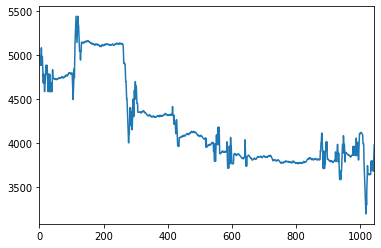

In [33]:
series = pd.Series(capital_stock)
series.plot()
pyplot.show()